<a href="https://colab.research.google.com/github/jdmedinatobon/proyectoMachineLearning/blob/master/EntrenamientoModelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Machine Learning
Juan David Medina y Jorge Felipe Gaviria

En este informe se presenta el proyecto final de Machine Learning. Este se realizó mediante el estudio realizado en el artíclo "Temporary Activation of Long-Term Memory Supports Working Memory". En este artículo, se buscaba determinar si a partir de imagenes de resonancia magnética funcional de cerebros de seres humanos se podía determinar aquello en lo que la persona estaba pensando. El estudio consistía en mostrarles a 10 sujetos de pruebas distintos imagenes mientras se les realizaba la resonancia. Las imagenes se dividían en 3 categorías (personas famosas, lugares famosos y objetos cotidianos). Los sujetos debían recordar aquella imagen que les fue mostrada previamente mientras se realizaba la resonancia y, a partir de los datos obtenidos, un clasificador debía determinar aquello que la persona estaba pensando. Para este proyecto se recaudaron los datos obtenidos, con los cuales se busca obtener un clasificador que permita identificar aquello que el sujeto de prueba estuviese mirando.

Este informe cuenta con un cuaderno de soporte utilizado para calcular los descriptores, a partir de las imágenes de resonancia magnética. Se recomienda leer dicho cuaderno antes que este.

La base de datos se puede obtener en https://openneuro.org/datasets/ds001497/versions/1.0.1, mientras que el artículo original se encuentra en https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2699183/.

El proyecto cuenta con un repositorio público en GitHub que se puede encontrar en el siguiente link: https://github.com/jdmedinatobon/proyectoMachineLearning

In [0]:
from google.colab import drive
drive.mount("/content/drive")#,force_remount = True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Es necesario ejecutar esta celda antes del resto, de lo contrario no van a funcionar de manera correcta. 
!pip3 install xgboost
!pip install seaborn
!pip install progressbar2
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.2)


#Librerías

In [0]:
#Se importan las librerias necesarias
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
import time

import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras
from keras import Sequential
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import GlobalAveragePooling3D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras import optimizers
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.models import model_from_json
from keras.models import Model
from keras.utils import model_to_dot
from keras.utils import plot_model
from IPython.display import SVG

import progressbar

!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
from google.colab.patches import cv2_imshow



Using TensorFlow backend.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  30898      0 --:--:-- --:--:-- --:--:-- 31073


#Clases

Primero, se crea la clase Resultados capaz de realizar diversas operaciones con los resultados obtenidos mediante el uso de los modelos. Mediante esta, se puede graficar la historia de entrenamiento, validación y calcular las estadísticas de precisión, recall y f1 con promedio macro de los modelos realizados.Esta clase además permite generar un reporte de las métricas y graficar la matriz de confusión.

In [0]:
#Clase utilizada para presentar los resultados de los modelos.
#En esta se incluye: una grafica de la historia de entrenamiento y validación,
#calculo de las metricas de accuracy, precision, recall y f1 con promedio macro,
#construccion de reporte de las metricas, grafica de la matriz de confusion.
class Resultados:
    def __init__(self, p_y_pred, p_y_true, pHist, pModelo, pId):
        self.y_pred = p_y_pred
        self.y_true = p_y_true
        self.hist = pHist
        self.modelo = pModelo
        self.iden = pId

    def graficarMatrizConfusion(self):
      cm = confusion_matrix(self.y_true, self.y_pred)
      
      plt.figure(figsize=(8,8))

      ax = sns.heatmap(cm, annot = True, cbar = False);
      
      ax.xaxis.tick_top()
      ax.xaxis.set_label_position('top')
      
      plt.xlabel("Clase Prediccion")
      plt.ylabel("Clase Verdadera")
      plt.title("Matriz de Confusion")

      plt.show()
      plt.savefig("drive/My Drive/DatosProyecto/results/MatrizConfusion_" + self.iden + ".png")

    def graficarHistoria(self):
      plt.plot(self.hist.history['sparse_categorical_accuracy'], label = 'Accuracy Entrenamiento')
      plt.plot(self.hist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
      plt.xlabel('Epoca')
      plt.ylabel('Accuracy')
      plt.title("Accuracy vs Epoca")
      plt.legend()
      plt.show()

    def calcularError(self):
      error = np.sum(self.y_pred != self.y_true)
      error = error/len(self.y_pred)

      return error

    def calcularF1(self):
      f1 = f1_score(self.y_true, self.y_pred, average = 'micro')
      return f1

    def calcularPrecision(self):
      precision = precision_score(self.y_true, self.y_pred, average = 'micro')
      return precision

    def calcularRecall(self):
      recall = recall_score(self.y_true, self.y_pred, average = 'micro')
      return recall

    def darReporte(self):
      print(classification_report(self.y_true, self.y_pred, labels = np.arange(0, max(self.y_true)+1)))


#Lectura de Datos

En esta sección se obtienen los datos utilizados para realizar el entrenamiento. Cabe resaltar que los datos recopilados de OpenNeuro no habían sido previamente preprocesados para realizar los modelos. Por este motivo, se utilizó un pre-procesador llamado easy fMRI mediante el cual fue posible eliminar partes indeseadas de la resonancia. Por ejemplo, mediante el uso de este preprocesador se logró eliminar parte de la cabeza osea que se había obtenido al realizar la resonancia, evitando así que hubiese información no relevante para entrenar y evaluar el clasificador. A continuación, se muestra lo obtenido al utilizar easy fmri. Con este preprocesador se pueden obtener imagenes en 3D del cerebro. En estas imagenes se evidencia que easy fmri elimina, en su mayoría, la cabeza osea de las resonancias.


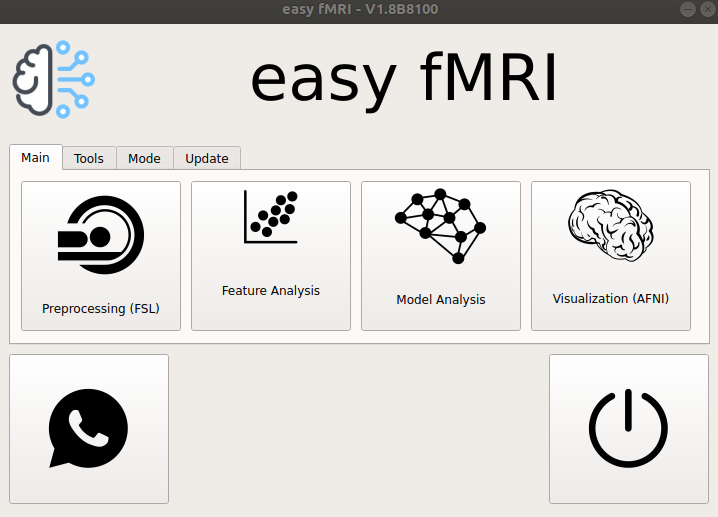

In [0]:

img = cv2.imread('drive/My Drive/ezfmri.png')
cv2_imshow(img)

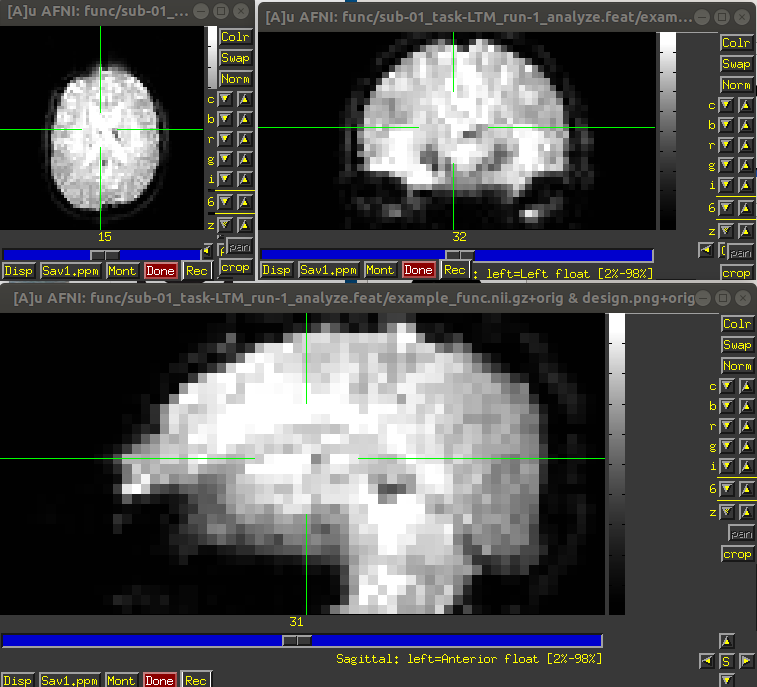

In [0]:
img = cv2.imread('drive/My Drive/preproces.png')
cv2_imshow(img)

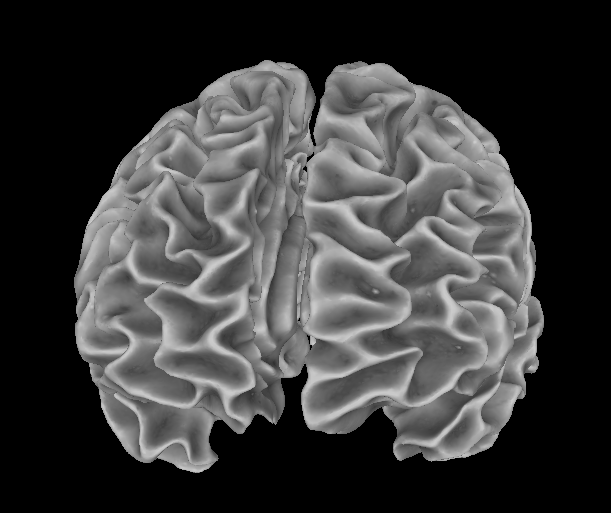

In [0]:
img = cv2.imread('drive/My Drive/prepros_foto_cerebro.png')
cv2_imshow(img)

En el siguiente gif se puede evidenciar la diferencia entre los datos brutos y posteriormente preprocesados mediante el uso de easy fmri:

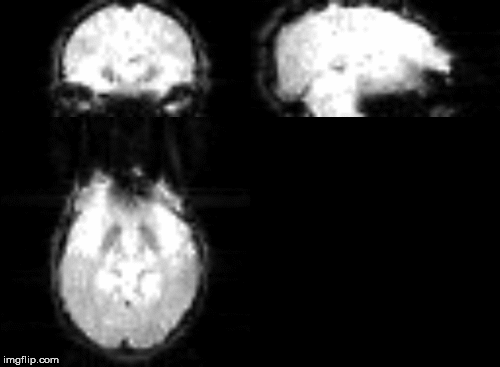

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

from pathlib import Path
gifPath = Path("drive/My Drive/DatosProyecto/results/GifPreprocesamiento.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

Adicionalmente, para la selección de los datos a utilizar se tuvo en cuenta la siguiente gráfica del artículo para evidenciar cuando los sujetos de prueba miraban las imagenes. Además, se tuvo en cuenta el retardo hemodinámico por lo cual los datos se deben correr 6 segundos referentes al momento en que se realiza la resonancia.

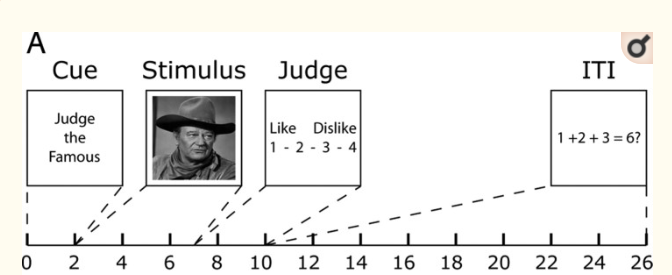

In [0]:
img = cv2.imread('drive/My Drive/DatosProyecto/results/long-term.PNG')
cv2_imshow(img)

 Además de lo anterior, se planteó utilizar descriptores que representaran la información de la resonancia de manera mas concisa. Para determinar estos descriptores, se utilizó la librería de python "mahotas: Computer Vision in Python". Mahotas es una librería para el procesamiento de imagenes. Los descriptores que se obtienen de esta librería son: "Los descriptores de Haralick", "Local binary patterns", "Threshold Adjacency Statistics" y "Zernike Moments". Además, también se calculan la media, la varianza, la kurtosis y skewness como descriptores adicionales.

El artículo original, en donde se explican en detalle los descriptores de Haralick y su uso para clasificar texturas se puede encontrar aquí: http://haralick.org/journals/TexturalFeatures.pdf.

In [0]:
pathDatos = "drive/My Drive/DatosProyecto/preprocessed/datosDescriptoresPreprocesadosPrimerosArreglados_3_7_1024.txt"
#pathDatos = "/content/drive/My Drive/datosDescriptoresV1_2_of.txt"
separador = ";"

#Esta funcion permite importar los datos, a partir del archivo de texto de descriptores.
#pRutaArchivo es la ruta del archivo con los descriptores de los datos. 
def importarDatos(pRutaArchivo):

  datos = []

  archivo = open(pRutaArchivo, "r")
  lineas = archivo.readlines()
  for linea in lineas:
    linea = linea.replace('\n','')
    muestra = linea.split(separador)
    muestra=np.array(muestra)

    datos.append(muestra.astype(float))
  datos=np.array(datos)
  datosx=datos[:,0:datos[0].shape[0]-2]
  datosy=datos[:,datos[0].shape[0]-1]
  datosy=datosy.astype(int)
  return datosx,datosy
    
def pruebaBinaria(pEtiquetas):
  etiquetasBinarias = np.zeros(len(pEtiquetas))
  etiquetasBinarias[pEtiquetas==2]=1
  return etiquetasBinarias

In [0]:
#datos_x, datos_y = importarDatos(pathDatos)
datos_x = np.load("drive/My Drive/DatosProyecto/preprocessed/Datos_3_7.npy")
datos_y = np.load("drive/My Drive/DatosProyecto/preprocessed/Etiquetas_3_7.npy")

# datos_x = np.load("drive/My Drive/DatosProyecto/raw/Datos_3_7.npy")
# datos_y = np.load("drive/My Drive/DatosProyecto/raw/Etiquetas_3_7.npy")

print(datos_x.shape)
print(datos_y.shape)

# datos_y_binarios = pruebaBinaria(datos_y)

(4425, 64, 64, 30)
(4425,)




# Preprocesamiento

Para los descriptores obtenidos, se plantea realizar métodos de preprocesamiento sobre los mismos. En esta sección, se crean los métodos para normalizar, obtener las componentes principales y blanquear.

Cabe resaltar que cada uno de estos tipos de preprocesamiento se calcula a partir de únicamente los datos de entrenamiento. Para preprocesar los datos de validación se utilizan los mismos que se encontraron con los de entrenamiento. Además, el cálculo de componentes principales se realiza con los datos normalizados.

In [0]:
#Funcion para normalizar los datos.
#pDatos_Para_Normalizar: Son los datos con respecto a los cuales se normaliza.
#pDatos: Son los datos a normalizar.
def normalizar(pDatos_Para_Normalizar, pDatos):
 #Se inicializa el preprocesamiento de los datos
  normalizar = preprocessing.Normalizer().fit(pDatos_Para_Normalizar) #se obtiene una funcion que permita a 
  #partir de la media y los valores maximos y minimos de los datos de entrenamiento de este modelo, normalizar los datos de prueba y de entrenamiento
  dato_normal = normalizar.transform(pDatos) #Datos normailzados y con los cuales se entrenarán los modelos 
  return dato_normal

#Funcion que calcula las componentes principales de x.
#pNumComponentes: Es el numero de componentes principales que se van a calcular. Enviar -1 si se quiere calcular todas.
def darComponentesPrincipales(x, pNumComponentes):

    if(pNumComponentes != -1):
      pca = PCA(n_components = pNumComponentes)
    else:
      pca = PCA()
      
    pca.fit(x)
    return pca

#Funcion que retorna las componentes utilizadas para blanquear los datos.
def darBlanqueamiento(x):
    pca = PCA(whiten = True)
    pca.fit(x)
    return pca

En las siguientes líneas de código se realiza la división entre los datos de entrenamiento y los de validación. Con los datos de entrenamiento se entrenaran los modelos, mientras que los de validación se utilizarán para estimar el desempeño de dichos modelos.

In [0]:
datos_x = np.reshape(datos_x, (datos_x.shape[0],64,64,30,1))
x_train, x_test, y_train, y_test = train_test_split(datos_x, datos_y, random_state = 0, test_size=0.10)

In [0]:
#print(datos_x.shape)
#datos_x = datos_x[:,1::]
#print(datos_x.shape)

In [0]:
#Normalizar los datos
x_train_norm = normalizar(x_train, x_train)
x_test_norm = normalizar(x_train, x_test)

#Calcular los datos con el 99% de la varianza explicada en las componentes principales
pca = darComponentesPrincipales(x_train_norm,-1)
x_train_pca = pca.transform(x_train_norm)
x_test_pca = pca.transform(x_test_norm)

#Blanquear los datos
blan = darBlanqueamiento(x_train)
x_train_blan = blan.transform(x_train)
x_test_blan = blan.transform(x_test)

In [0]:
#Prueba categorical
def prepararClases(pY1, pY2):
  ohe = preprocessing.OneHotEncoder(categories = 'auto')
  y = np.reshape(pY1, (-1,1))
  ohe.fit(y)

  y2 = np.reshape(pY2, (-1,1))

  return ohe.transform(y).toarray(), ohe.transform(y2).toarray()

In [0]:
y2, y3 = prepararClases(y_train, y_test)

A continuación, se obtienen las componentes principales de los descriptores. Se evidencia en la primera gráfica obtenida que la varianza representada en las dimensiones obtenidas se acumula principalmente en una que explica el 85.7% de la varianza seguida de otra que con el 13.7%. Además, en la segunda gráfica se pueden ver los valores en valor absoluto de cada elemento de la componente de mayor varianza. Finalmente, en la tercera se grafica la clase correspondiente a cada dato proyectado sobre esta primera componente principal. En esta se puede ver que no hay una separación clara para los datos.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


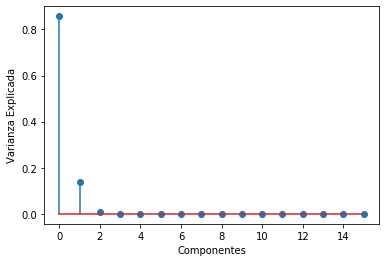

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


[8.56872994e-01 1.36817170e-01 6.30697442e-03 2.09144076e-06
 7.36666140e-07 3.05717846e-08 1.24712951e-09 8.41796108e-10
 4.57476454e-10 3.57941017e-10 1.56431703e-12 5.25442851e-13
 3.19776801e-13 1.82214980e-18 2.04579402e-20 4.43881691e-27]


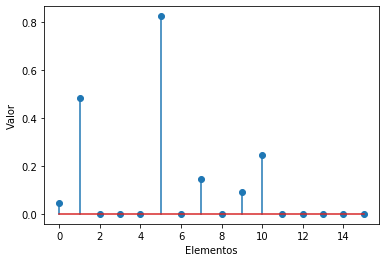

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


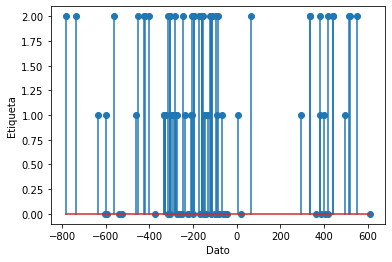

In [0]:
#Grafica la varianza explicada (en porcentaje) por cada componente principal calculada con los datos de entrenamiento.
pca = darComponentesPrincipales(x_train_norm,-1)
plt.xlabel("Componentes")
plt.ylabel("Varianza Explicada")
plt.stem((pca.explained_variance_ratio_))
plt.show()

print(pca.explained_variance_ratio_)

#Grafica de la componente que explica la mayor varianza.
plt.xlabel("Elementos")
plt.ylabel("Valor")
plt.stem((abs(pca.components_[0])))
plt.show()


#Grafica de la componente que explica la mayor varianza.
plt.xlabel("Dato")
plt.ylabel("Etiqueta")
plt.stem((np.dot(x_train[0:100],pca.components_[0])),y_train[0:100])
plt.show()


#Entrenamiento de los Modelos
Dado lo anterior, se procede a plantear y entrenar diferentes modelos con el fin de encontrar un buen clasificador.

#Perceptrón Multicapa
Primero se intenta utilizar un perceptron multicapa como clasificador. Sin embargo, el entrenamiento del mismo no muestra un crecimiento en cuanto al porcentaje de acierto del modelo como se puede apreciar en la gráfica "Probabilidad de acierto contra número de iteraciones". Cabe resaltar que este clasificador es entrenado con los descriptores obtenidos a partir de los datos de easy fmri.

In [0]:
n=10
error=[]
Proba_error_prueba=100000
error_actual=1000000
Proba_error_prueba_tan=100000
modeloPrueba = MLPClassifier(activation = 'relu',hidden_layer_sizes=(n,2), max_iter=1, batch_size=2, solver='adam', tol=0.001, warm_start =True,momentum=0.6, learning_rate_init=0.001, learning_rate = 'adaptive', nesterovs_momentum=True, power_t=0.5)#0.6
for i in range(0,150):
    modeloPrueba.fit(x_train,y_train)
    error_actual = 1-modeloPrueba.score(x_test,y_test)
    error.append(error_actual)
    if(error_actual<Proba_error_prueba):
        N_neuronas=n
        fcn_activacion="tanh"
        modelo = modeloPrueba
        Proba_error_prueba = error_actual
    if(error_actual<Proba_error_prueba_tan):
        N_neuronas_tan=n
        modelo_tan = modeloPrueba
        Proba_error_prueba_tan = error_actual
print("Número de neuronas utilizadas para la mejor probabilidad de error")
print("Mejor probabilidad de acierto")
print(1-Proba_error_prueba_tan)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Número de neuronas utilizadas para la mejor probabilidad de error
Mejor probabilidad de acierto
0.3363431151241535


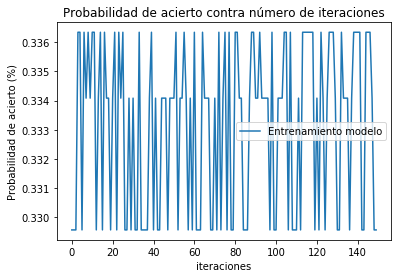

In [0]:
plt.plot((1-np.array(error)), label = "Entrenamiento modelo") 
plt.xlabel('iteraciones') 
plt.ylabel('Probabilidad de acierto (%)') 
plt.title('Probabilidad de acierto contra número de iteraciones') 
plt.legend() 
plt.show()

#Árboles de Decisión
Posteriormente, se plantea un modelo a partir de árboles de decisión y adaboost utilizando los descriptores normalizados. A continuación, se entrena el modelo mediante el uso de los descriptores normalizados. Se evidencia que a pesar de que en los datos de entrenamiento se tenga un 99% de acierto, en los datos de validacióón se optiene apenas un 37% de acierto.

Porcentaje de acierto utilizando datos de entrenamiento normalizados
0.9959819186338523
Porcentaje de acierto utilizando datos de validacion normalizados
0.35665914221218964


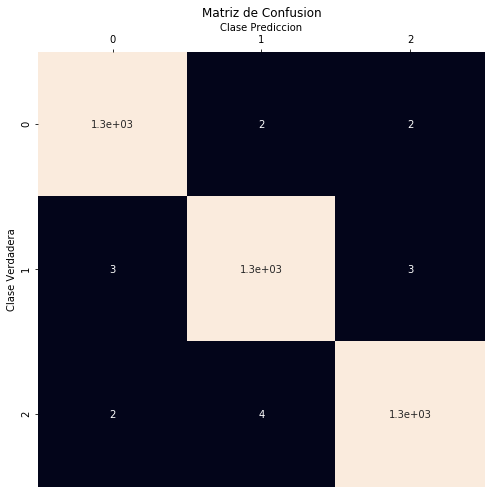

<Figure size 432x288 with 0 Axes>

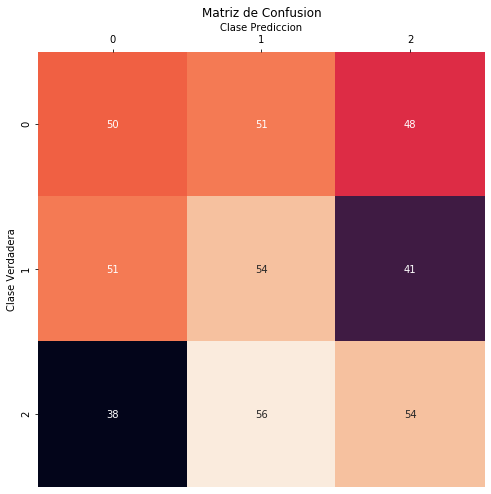

<Figure size 432x288 with 0 Axes>

In [0]:
rng = np.random.RandomState(1)

tree = DecisionTreeClassifier(max_depth = 4)

modelo = AdaBoostClassifier(base_estimator = tree, n_estimators = 1000, learning_rate=1.0, random_state=rng)
modelo.fit(x_train_norm,y_train)

print("Porcentaje de acierto utilizando datos de entrenamiento normalizados")
print(modelo.score(x_train_norm,y_train))
print("Porcentaje de acierto utilizando datos de validacion normalizados")
print(modelo.score(x_test_norm,y_test))

resultadosArbol = Resultados(modelo.predict(x_train_norm), y_train, [], modelo, "Ba")
resultadosArbol.graficarMatrizConfusion()
resultadosArbol = Resultados(modelo.predict(x_test_norm), y_test, [], modelo, "Ba")
resultadosArbol.graficarMatrizConfusion()

A continuación, se presenta el modelo entrenado mediante los datos de fmri preprocesados mediante easy fmri.

#SVM

Acierto de Entrenamiento con SVM: 0.3302360622802612
Acierto de Validación con SVM: 0.3115124153498871


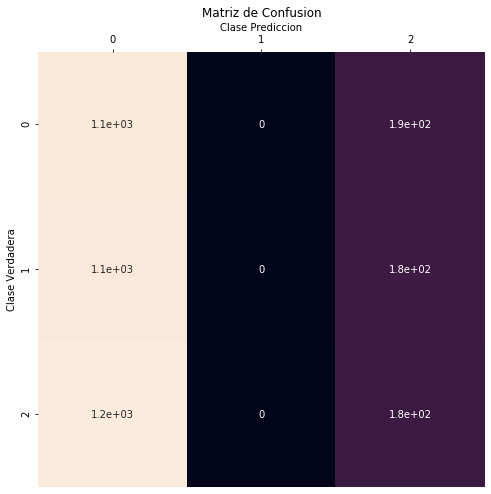

<Figure size 432x288 with 0 Axes>

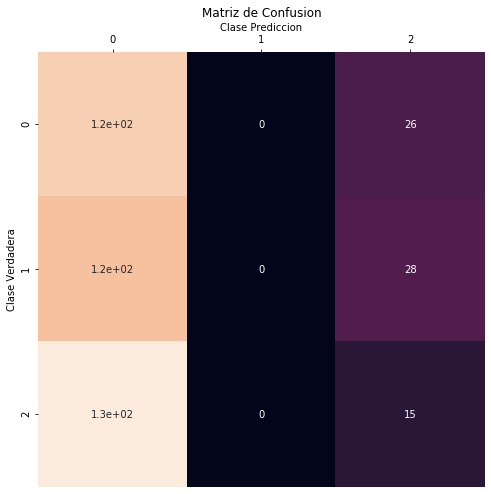

<Figure size 432x288 with 0 Axes>

In [0]:
modelo = SVC(C = 10**9, kernel = 'rbf', gamma = 'scale')
modelo.fit(x_train_norm, y_train)

print("Acierto de Entrenamiento con SVM: {}".format(modelo.score(x_train_norm,y_train)))
print("Acierto de Validación con SVM: {}".format(modelo.score(x_test_norm,y_test)))

resultadosSVM = Resultados(modelo.predict(x_train_norm), y_train, [], modelo, "Basss")
resultadosSVM.graficarMatrizConfusion()
resultadosSVM = Resultados(modelo.predict(x_test_norm), y_test, [], modelo, "Bassss")
resultadosSVM.graficarMatrizConfusion()

#Keras
Se procede a utilizar una Red Convolucional de 3 dimensiones como modelo. Para esta red se utilizan como datos de entrenamiento los datos procesados mediante easy fmri. Cabe resaltar que en estos datos muchos de los valores son cero debido a que la mayor parte de la imagen no corresponde a partes del cerebro. Lo anterior podría afectar el clasificador obtenido. A su vez, se crea un modelo perceptrón multinivel pero implementado utilizando Keras.

In [0]:
#Estas funciones permiten guardar y cargar un modelo, a partir de las rutas indicadas por parametro.
def guardarModelo(pModelo, pRutaModelo, pRutaPesos, pRutaDiagrama):
  modelo_json = pModelo.to_json()

  with open(pRutaModelo, "w") as archivo_json:
      archivo_json.write(modelo_json)

  pModelo.save_weights(pRutaPesos)

  plot_model(pModelo, to_file = pRutaDiagrama, show_shapes = True)

def cargarModelo(pRutaModelo, pRutaPesos):
  archivo_json = open(pRutaModelo, 'r')
  modelo_json = archivo_json.read()
  archivo_json.close()
  modelo = model_from_json(modelo_json)

  modelo.load_weights(pRutaPesos)

  return modelo

def crearModelo():
  modelo = Sequential()
  modelo.add(Dense(64, use_bias = True, kernel_initializer='random_uniform', activation = "relu",activity_regularizer=l2(alpha), input_dim = 16))
  modelo.add(Dense(32, use_bias = True, activation = "relu"))
  modelo.add(Dense(16, use_bias = True, activation = "sigmoid"))
  modelo.add(Dense(numClases, activation = "softmax"))

  sgd = optimizers.SGD(lr = tasa)

  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = sgd, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo

def crearModelo2(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  modelo.add(MaxPooling3D(int(pTamPooling[0]), padding='same',input_shape = (64, 64, 30, 1)))
  modelo.add(Conv3D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', padding='same'))

  modelo.add(Conv3D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu', padding='same'))
  modelo.add(MaxPooling3D(int(pTamPooling[1]), padding='same'))
  
  modelo.add(Conv3D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu', padding='same'))
  modelo.add(MaxPooling3D(int(pTamPooling[2]), padding='same'))

  # modelo.add(Conv3D(pNumFiltros[3], int(pTamFiltros[3]), activation = 'relu'))
  # modelo.add(GlobalAveragePooling3D())
  modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)

  modelo.add(Dense(numClases, activation = 'softmax'))

  sgd = optimizers.SGD(lr = pTasa, momentum=0.9)
  adam = optimizers.Adam(lr = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo


def crearModelo3(pTasa, pAlpha, pOptimizer):
  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  modelo.add(MaxPooling3D(int(tamPooling[0]), padding='same',input_shape = (64, 64, 30, 1)))
  modelo.add(Conv3D(numFiltros[0], int(tamFiltros[0]), activation = 'relu', padding='same'))
  
  modelo.add(MaxPooling3D(int(tamPooling[1]), padding='same'))
  modelo.add(Conv3D(numFiltros[1], int(tamFiltros[1]), activation = 'relu', padding='same'))
  
  #modelo.add(Conv3D(numFiltros[2], int(tamFiltros[2]), activation = 'relu', padding='same'))
  #modelo.add(MaxPooling3D(int(tamPooling[2]), padding='same'))

  # modelo.add(Conv3D(pNumFiltros[3], int(pTamFiltros[3]), activation = 'relu'))
  # modelo.add(GlobalAveragePooling3D())
  modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)

  modelo.add(Dense(numClases, activation = 'softmax'))

  sgd = optimizers.SGD(lr = pTasa, momentum=0.9)
  adam = optimizers.Adam(lr = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])

  return modelo

A continuación se presenta la arquitectura del modelo creado:


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_12 (MaxPooling (None, 16, 16, 8, 1)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 16, 16, 8, 100)    2800      
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 16, 8, 100)    270100    
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 8, 4, 100)      0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 8, 4, 100)      270100    
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 4, 4, 2, 100)      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)             

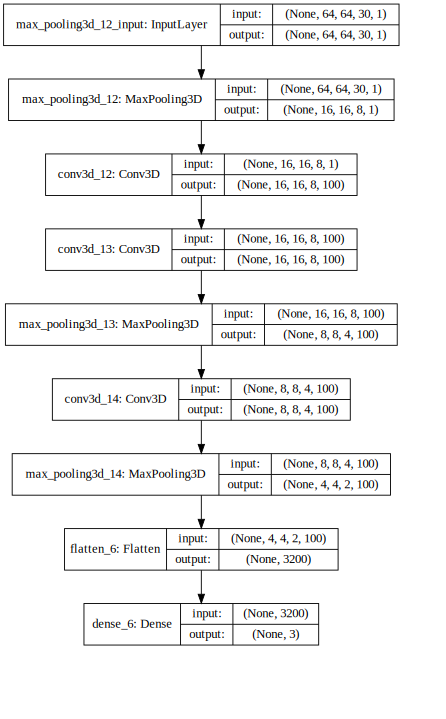

In [0]:
#Esta celda construye los modelos, a partir de los parametros especificados por cada una de las siguientes variables.

#Es el numero de clases.
numClases = 3

#Es el numero de filtros que cada capa convolucional utiliza.
numFiltros = np.array([100, 100, 100, 10, 10, 10])

#Es el tamaño de los filtros utilizados en cada capa convolucional.
tamFiltros = np.array([3, 3, 3, 8, 8, 5])

#Es el tamaño de cada capa de Pooling.
tamPooling = np.array([4, 2, 2, 3, 3, 3])

#Es el numero de neuronas en cada capa de la red neuronal que sigue despues de la parte convolucional.
numNeuronas = np.array([10, 20, 10])

#Es el tipo de optimizador a utilizar.
#Se pueden especificar: "sgd", "adam" o "rmsprop"
optimizer="sgd"

#Es la tasa de aprendizaje del optimizador.
tasa = 0.1

#Es el parametro de regularizacion a utilizar.
alpha = 0.01

# modelo = crearModelo()
modelo = crearModelo2(tasa, alpha, numFiltros, tamFiltros, tamPooling, numNeuronas, optimizer)

#Esta linea muestra un diagrama de la red neuronal.
SVG(model_to_dot(modelo, show_shapes = True, expand_nested = True, dpi = 65).create(prog='dot', format='svg'))

A continuación se muestra el entrenamiento de la arquitectura mostrada anteriormente. Se puede evidenciar como el porcentaje de acierto del modelo no logra ser superior a 33%.

In [0]:
epocas = 5
batchSize = 32

rutaModelo = "drive/My Drive/ModelosProyecto/Modelo.json"
rutaPesos = "drive/My Drive/ModelosProyecto/PesosModelo.h5"
rutaDiagrama = "drive/My Drive/ModelosProyecto/DiagramaModelo.png"

hists = []

for i in range(0,1):
  hist = modelo.fit(x_train, y2, verbose = 1, validation_data=(x_test, y3), epochs = epocas, batch_size = batchSize)
  
  hists.append(hist)

Train on 3982 samples, validate on 443 samples
Epoch 1/5
3982/3982 [==============================] - 24s 6ms/step - loss: 10.7508 - categorical_accuracy: 0.3330 - val_loss: 10.6969 - val_categorical_accuracy: 0.3363
Epoch 2/5
3982/3982 [==============================] - 24s 6ms/step - loss: 10.7508 - categorical_accuracy: 0.3330 - val_loss: 10.6969 - val_categorical_accuracy: 0.3363
Epoch 3/5
3982/3982 [==============================] - 24s 6ms/step - loss: 10.7508 - categorical_accuracy: 0.3330 - val_loss: 10.6969 - val_categorical_accuracy: 0.3363
Epoch 4/5
3982/3982 [==============================] - 24s 6ms/step - loss: 10.7508 - categorical_accuracy: 0.3330 - val_loss: 10.6969 - val_categorical_accuracy: 0.3363
Epoch 5/5
3982/3982 [==============================] - 24s 6ms/step - loss: 10.7508 - categorical_accuracy: 0.3330 - val_loss: 10.6969 - val_categorical_accuracy: 0.3363


#AdaBoost
En esta sección, se crea un clasificador adaboost cuyo estimador base fuese una red convolucional de 3 dimensiones. En esta sección también se utilizaron otros estimadores base como árboles de decisión, sin embargo ninguno logró un desempeño adecuado. Los resultados se muestran a continuación:

In [0]:
epocas = 2
batchSize = 32

estimadorBase = KerasClassifier(build_fn = crearModelo3, epochs = epocas, batch_size = batchSize, verbose = 1, pTasa = tasa, 
                                pAlpha = alpha, pOptimizer = optimizer) 

Epoch 1/2
3982/3982 [==============================] - 3s 787us/step - loss: 0.0027 - sparse_categorical_accuracy: 0.3305
Epoch 2/2
3982/3982 [==============================] - 2s 557us/step
Epoch 1/2
3982/3982 [==============================] - 3s 791us/step - loss: 0.0020 - sparse_categorical_accuracy: 0.3338
Epoch 2/2
3982/3982 [==============================] - 2s 593us/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1326
           1       0.33      1.00      0.50      1329
           2       0.00      0.00      0.00      1327

    accuracy                           0.33      3982
   macro avg       0.11      0.33      0.17      3982
weighted avg       0.11      0.33      0.17      3982



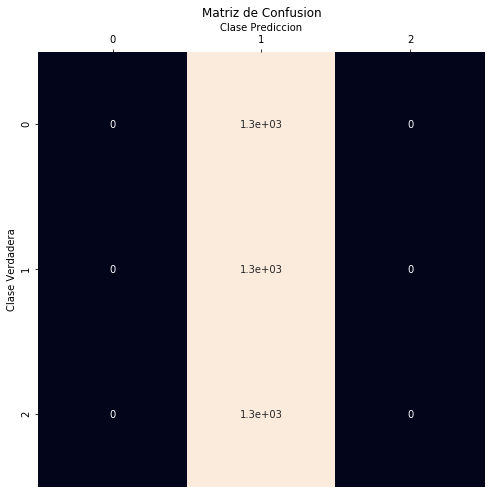

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.33      1.00      0.50       146
           2       0.00      0.00      0.00       148

    accuracy                           0.33       443
   macro avg       0.11      0.33      0.17       443
weighted avg       0.11      0.33      0.16       443



<Figure size 432x288 with 0 Axes>

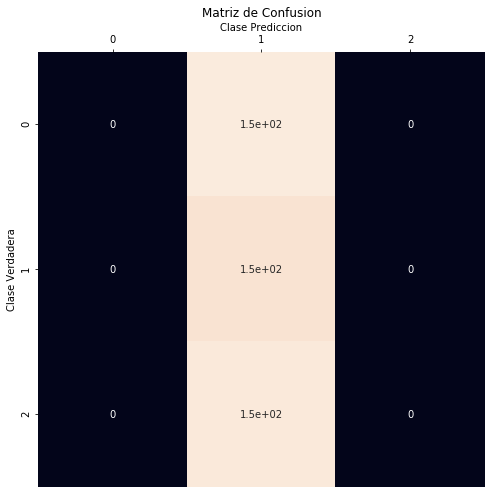

<Figure size 432x288 with 0 Axes>

In [0]:
numEstimadores = 2

xEnt = x_train
xVal = x_test

adaBoost = AdaBoostClassifier(base_estimator = estimadorBase, n_estimators = numEstimadores)
adaBoost.fit(xEnt, y_train)

resultadosAdaBoost = Resultados(modelo.predict_classes(xEnt), y_train, [], modelo, "AdaBoost")
resultadosAdaBoost.darReporte()
resultadosAdaBoost.graficarMatrizConfusion()
resultadosAdaBoost = Resultados(modelo.predict_classes(xVal), y_test, [], modelo, "AdaBoost")
resultadosAdaBoost.darReporte()
resultadosAdaBoost.graficarMatrizConfusion()


# Conclusiones
El mejor modelo obtenido resulta ser el adaboost impementado con árboles de decisión. Cabe aclarar que este modelo fue entrenado con los descriptores determinados al utilizar el código desarrollado para esto. A pesar de que este fuese el mejor modelo determinado, este no supera un 37% de porcentaje de acierto por sobre los datos de validación. Aún asi, también se debe tener en cuenta que se utilizan pocos datos de validación, motivo por el cual es posible que esta estimación del error no sea confiable y no refleje el comportamiento que el modelo tendría en el mundo real.

Uno de los motivos por los cuales posiblemente no se logró determinar un buen modelo puede ser la resolución de las imagenes que se tienen. Lo anterior teniendo en cuenta que para imágenes de resonancia magnética se puede encontrar imagenes con resoluciones más altas como 240x240, mientras que las imagenes utilizadas son de 64x64. 

Es también posible que a partir de descriptores o redes convolucionales 3D no sea posible adquirir un buen modelo. Cabe aclarar que en el artículo seleccionan los pixeles que mas presentan cambios al variar de imagen y con base en esto crean los modelos. Lo anterior es una manera distinta de solucionar el problema, ya que únicamente utilizan la información de pixeles específicos, en vez de calcular descriptores con toda la información de las imágenes. Esto, además, también tiene un mejor soporte en la teoría, por lo que se van a contar con diferentes regiones del cerebro que van a variar en su actividad a medida que se varía el objeto, lugar o persona. 

Como trabajo futuro se plantearía como primera prioridad la construcción de una base de datos con una cantidad mayor de datos. Para el entrenamiento de redes profundas, por ejemplo redes convolucionales, es deseable contar con una cantidad enorme de datos, ya que los modelos utilizan números grandes de parámetros. Además, también se puede explorar la posibilidad de utilizar una red convolucional ya entrenada para resolver algún problema relacionado a imágenes de resonancia magnética. Se podría tomar la parte de la red que calcula la representación de los datos brutos y utilizarla para obtener los descriptores para entrenar diferentes modelos.